In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import torch.nn.functional as F  
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import matplotlib.pyplot as plt
import gc
from torchvision.utils import save_image
from torchvision import datasets, transforms
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.optim as optim


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing

In [2]:
def data_loader(data_dir,
                batch_size,
                random_seed=42,
                valid_size=0.1,
                shuffle=True,
                test=False,
                augment=False):  # Add augment parameter
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    if augment:
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(),  # Add data augmentation transforms
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
        ])

    if test:
        dataset = datasets.ImageFolder(
            root=data_dir + '/test',
            transform=transform
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    if augment:
        dataset = datasets.ImageFolder(
            root=data_dir + '/train',
            transform=transform
        )
    else:
        dataset = datasets.ImageFolder(
            root=data_dir + '/train',
            transform=transform
        )

    num_train = len(dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)

train_loader, valid_loader = data_loader(data_dir='/kaggle/input/architectural-heritage-elements-image64-dataset',
                                         batch_size=64, augment=True)

test_loader = data_loader(data_dir='/kaggle/input/architectural-heritage-elements-image64-dataset',
                          batch_size=64,
                          test=True)


# Model Building

Resnet

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.1))  # Dropout added after ReLU
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.1))  # Dropout added after ReLU
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.activations = []  # To store intermediate activations
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        self.activations = []  # Clear previous activations
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        self.activations.append(x.clone())  # Store activation for layer 0
        x = self.layer1(x)
        self.activations.append(x.clone())  # Store activation for layer 1
        x = self.layer2(x)
        self.activations.append(x.clone())  # Store activation for layer 2
        x = self.layer3(x)
        self.activations.append(x.clone())  # Store activation for layer 3
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x



In [4]:
num_classes = 10
num_epochs = 25
batch_size = 16
learning_rate = 0.001

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

Training

Epoch [1/25], Training Loss: 1.2077, Precision: 0.4087, Recall: 0.2888, F1 Score: 0.3385
Validation Loss: 1.0595, Accuracy: 63.38%
Epoch [2/25], Training Loss: 1.0001, Precision: 0.4541, Recall: 0.3827, F1 Score: 0.4153
Validation Loss: 0.9164, Accuracy: 67.72%
Epoch [3/25], Training Loss: 0.8432, Precision: 0.5206, Recall: 0.4879, F1 Score: 0.5037
Validation Loss: 0.8893, Accuracy: 69.30%
Epoch [4/25], Training Loss: 0.7499, Precision: 0.6126, Recall: 0.5778, F1 Score: 0.5947
Validation Loss: 0.7477, Accuracy: 73.25%
Epoch [5/25], Training Loss: 0.6844, Precision: 0.6055, Recall: 0.6168, F1 Score: 0.6111
Validation Loss: 0.6337, Accuracy: 78.38%
Epoch [6/25], Training Loss: 0.6023, Precision: 0.6578, Recall: 0.6514, F1 Score: 0.6546
Validation Loss: 0.6577, Accuracy: 77.20%
Epoch [7/25], Training Loss: 0.5634, Precision: 0.6745, Recall: 0.6892, F1 Score: 0.6818
Validation Loss: 0.5750, Accuracy: 78.97%
Epoch [8/25], Training Loss: 0.5132, Precision: 0.7000, Recall: 0.7133, F1 Score: 0

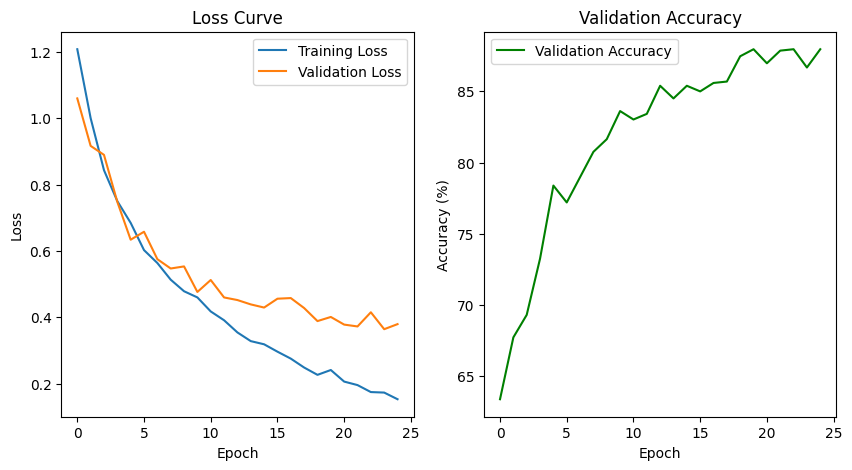

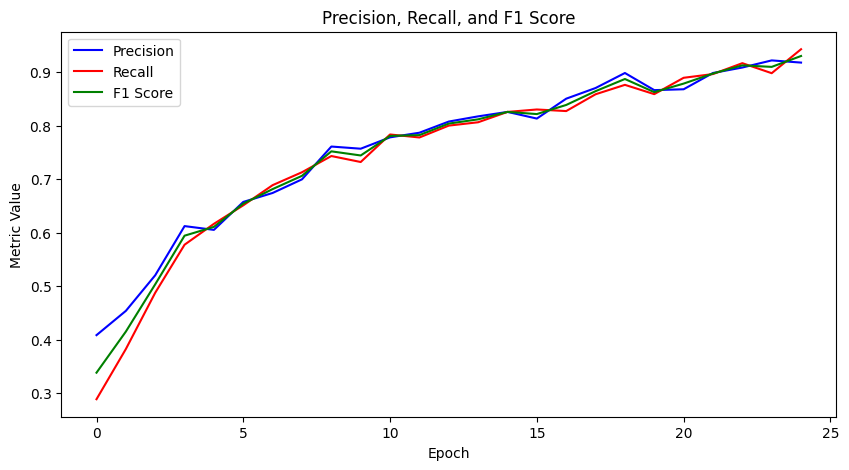

In [6]:
train_losses = []
valid_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct = 0
    total_predictions = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        true_positives += ((predicted == labels) & (predicted == 1)).sum().item()
        false_positives += ((predicted != labels) & (predicted == 1)).sum().item()
        false_negatives += ((predicted != labels) & (predicted == 0)).sum().item()
        
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print('Epoch [{}/{}], Training Loss: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}' 
          .format(epoch+1, num_epochs, avg_train_loss, precision, recall, f1))
            
    
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
    
        print('Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(avg_valid_loss, accuracy)) 

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# Plot precision, recall, and F1 score
plt.figure(figsize=(10, 5))
plt.plot(precisions, label='Precision', color='blue')
plt.plot(recalls, label='Recall', color='red')
plt.plot(f1_scores, label='F1 Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.show()


In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network: {} %'.format(100 * correct / total))


Accuracy of the network: 86.53846153846153 %


# Decovolution

In [ ]:
class Visualizer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Visualizer, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()  
        )
        self.deconv.to(device)

    def forward(self, x):
        return self.deconv(x)

def visualize_feature_maps(model, image, layer_id=0):
    model(image)
    activations = model.activations
    activation = activations[layer_id]
    visualizer = Visualizer(activation.size(1), 3) 
    activation = activation.unsqueeze(0) if activation.dim() == 3 else activation
    visualized_maps = visualizer(activation)
    return visualized_maps


for images, _ in test_loader:
    image = images[0]  
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
image = image.unsqueeze(0).to(device)  

def plot_heatmap_with_image(heatmap, image, cmap='viridis', alpha=0.6, vmin=None, vmax=None):
    heatmap_numpy = heatmap.cpu().detach().numpy()
    image_numpy = image.squeeze(0).cpu().detach().numpy()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_numpy.transpose(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')
    num_channels = heatmap_numpy.shape[1]
    plt.subplot(1, 2, 2)
    for i in range(num_channels):
        heatmap_channel = heatmap_numpy[0, i, :, :]
        plt.imshow(heatmap_channel, cmap=cmap, interpolation='nearest', alpha=alpha, vmin=vmin, vmax=vmax)
        plt.title(f'Heatmap (Channel {i+1})')
        plt.axis('off')

    plt.show()

visualized_feature_maps = visualize_feature_maps(model, image, layer_id=1)
plot_heatmap_with_image(visualized_feature_maps, image, cmap='hot', alpha=0.8, vmin=0.2, vmax=0.8)

# Image Generation for Specific Classes

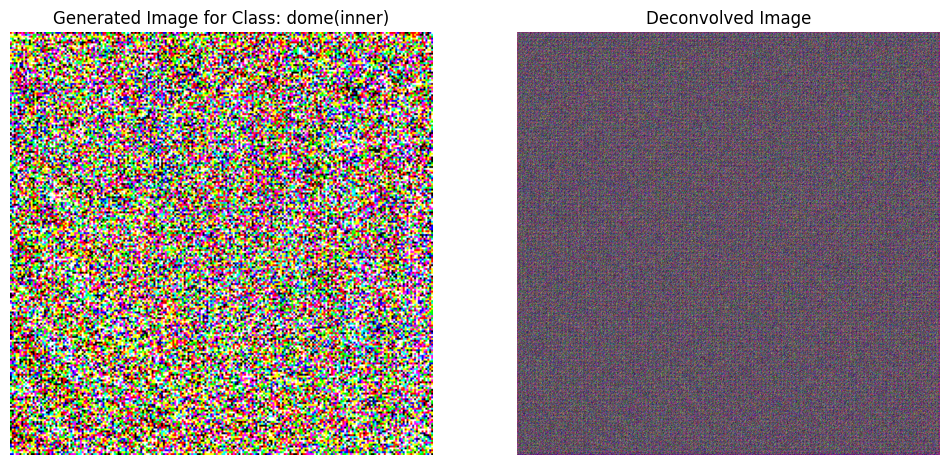

In [27]:
class_names = {
    0: "altar",
    1: "apse",
    2: "bell_tower",
    3: "column",
    4: "dome(inner)",
    5: "dome(outer)",
    6: "flying_buttress",
    7: "gargoyle",
    8: "stained_glass",
    9: "vault"
}

def generate_image_for_class(model, target_class, num_steps=1000, lr=0.1, device='cuda'):
    input_image = torch.rand((1, 3, 224, 224), requires_grad=True, device=device)

    model.eval()
    model.to(device)

    # Define optimizer
    optimizer = optim.Adam([input_image], lr=lr)

    # Optimization loop
    for _ in range(num_steps):
        optimizer.zero_grad()

        # Forward pass
        output = model(input_image)

        loss = -output[0, target_class]

        # Backpropagation
        loss.backward()
        optimizer.step()

    generated_image = input_image.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
    generated_image = np.clip(generated_image, 0, 1)

    return generated_image

def deconvolution(model, generated_image, target_class_index, device='cuda'):
    model.eval()

    activation = None

    def hook(module, input, output):
        nonlocal activation
        activation = output

    target_layer = None
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            break
        target_layer = module

    target_layer.register_forward_hook(hook)

    input_tensor = torch.tensor(generated_image.transpose(2, 0, 1)).unsqueeze(0)
    input_tensor = input_tensor.to(device)
    output = model(input_tensor)

    if activation is None:
        raise ValueError("Activation is None. Ensure that the hook function is properly capturing activations.")

    decoder = nn.Sequential(
        nn.ConvTranspose2d(activation.size(1), 256, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU(),
        nn.BatchNorm2d(256).to(device),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU(),
        nn.BatchNorm2d(128).to(device),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU(),
        nn.BatchNorm2d(64).to(device),
        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1).to(device),
        nn.ReLU()  
    )

    normalized_activation = torch.nn.functional.normalize(activation)

    reconstructed_image = decoder(normalized_activation)


    return reconstructed_image.detach().cpu().squeeze().numpy().transpose(1, 2, 0)


target_class_index = 4  
generated_image = generate_image_for_class(model, target_class_index)
deconvolved_image = deconvolution(model, generated_image, target_class_index)

# Visualize the generated image and deconvolved image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(generated_image)
plt.title('Generated Image for Class: ' + class_names[target_class_index])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(deconvolved_image)
plt.title('Deconvolved Image')
plt.axis('off')

plt.show()

# without pooling

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.1))  # Dropout added after ReLU
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(p=0.1))  # Dropout added after ReLU
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.activations = []  # To store intermediate activations
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        self.activations = []  # Clear previous activations
        x = self.conv1(x)
        x = self.layer0(x)
        self.activations.append(x.clone())  # Store activation for layer 0
        x = self.layer1(x)
        self.activations.append(x.clone())  # Store activation for layer 1
        x = self.layer2(x)
        self.activations.append(x.clone())  # Store activation for layer 2
        x = self.layer3(x)
        self.activations.append(x.clone())  # Store activation for layer 3
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output tensor
        x = self.fc(x)
        return x



In [20]:
num_classes = 10
num_epochs = 25
batch_size = 16
learning_rate = 0.001

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [21]:
total_step = len(train_loader)
train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    print ('Epoch [{}/{}], Training Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, avg_train_loss))
            
    # Validation
    with torch.no_grad():
        valid_loss = 0.0
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
    
        print('Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(avg_valid_loss, accuracy)) 

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 26.12 MiB is free. Process 2223 has 15.87 GiB memory in use. Of the allocated memory 15.14 GiB is allocated by PyTorch, and 423.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF